In [4]:
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import plotly.express as px
import contextily as cx


In [5]:
#Read in the shapefiles from the local directory within a for loop

data_files = Path("../Resources/Shapefiles")
shapefile_dfs = []
for data_file in data_files.glob("*.shp"):
    df = gpd.read_file(data_file)
    shapefile_dfs.append(df)
concat_shapefile_df = pd.concat(shapefile_dfs, ignore_index=True)

concat_shapefile_df.head(1)


,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Status,Connect,Form,TermType,Surging,Linkages,Name,GN_area,GN_comp_ye,geometry
0,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.668,63.404,1,2,0.558,1713,...,0,0,0,0,9,9,None,0.8415,1986,"POLYGON ((365095.000 1512465.000, 365125.000 1..."


DATA EXPLORATION

In [26]:
#Determine the number of rows in the concatenated table
concat_shapefile_df.shape

(287327, 25)

In [15]:
# View the columns of the shapefile
concat_shapefile_df.columns

Index(['RGIId', 'GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Surging',
       'Linkages', 'Name', 'GN_area', 'GN_comp_ye', 'geometry'],
      dtype='object')

In [6]:
#Copy the shapefile dataframe
shapefile_df = concat_shapefile_df.copy()
shapefile_df.head()


,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Status,Connect,Form,TermType,Surging,Linkages,Name,GN_area,GN_comp_ye,geometry
0,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.668,63.404,1,2,0.558,1713,...,0,0,0,0,9,9,None,0.8415,1986,"POLYGON ((365095.000 1512465.000, 365125.000 1..."
1,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.080,63.376,1,2,1.685,1609,...,0,0,0,0,9,9,None,1.1295,1986,"POLYGON ((394645.000 1512465.000, 394675.000 1..."
2,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.120,63.381,1,2,3.681,1273,...,0,0,0,0,9,9,None,1.9764,1986,"MULTIPOLYGON (((392485.000 1512435.000, 392485..."
3,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.057,63.551,1,2,2.573,1494,...,0,0,0,0,9,9,None,0.1584,1986,"POLYGON ((343285.000 1526025.000, 343315.000 1..."
4,RGI60-01.00006,G213756E63571N,20090703,-9999999,-146.244,63.571,1,2,10.470,1201,...,0,0,0,0,9,9,None,7.2504,1986,"MULTIPOLYGON (((385495.000 1537035.000, 385855..."


In [18]:
#Find the number of unique glacier ids in the concatenated file
unique_ids = (shapefile_df["GLIMSId"]).nunique()
unique_ids

18259

In [7]:
# Drop the irrelevant columns
shapefile_df_reduced = shapefile_df[["GLIMSId","CenLon", "CenLat", "Zmin", "Zmax", "Slope", "Lmax", "Form", "Name", "GN_area", "GN_comp_ye", "geometry"]]
shapefile_df_reduced.head()



,GLIMSId,CenLon,CenLat,Zmin,Zmax,Slope,Lmax,Form,Name,GN_area,GN_comp_ye,geometry
0,G213332E63404N,-146.668,63.404,1713,2144,16.0,1197,0,None,0.8415,1986,"POLYGON ((365095.000 1512465.000, 365125.000 1..."
1,G213920E63376N,-146.080,63.376,1609,2182,18.0,2106,0,None,1.1295,1986,"POLYGON ((394645.000 1512465.000, 394675.000 1..."
2,G213880E63381N,-146.120,63.381,1273,2317,19.0,4175,0,None,1.9764,1986,"MULTIPOLYGON (((392485.000 1512435.000, 392485..."
3,G212943E63551N,-147.057,63.551,1494,2317,16.0,2981,0,None,0.1584,1986,"POLYGON ((343285.000 1526025.000, 343315.000 1..."
4,G213756E63571N,-146.244,63.571,1201,3547,22.0,10518,0,None,7.2504,1986,"MULTIPOLYGON (((385495.000 1537035.000, 385855..."


In [8]:
#Compute the change in area between 1986 and 2020 for each glacier

area_1986_df = shapefile_df_reduced.loc[shapefile_df_reduced["GN_comp_ye"]== "1986", ["GLIMSId", "CenLon", "CenLat", "Name","GN_area","geometry",]]
area_2020_df = shapefile_df_reduced.loc[shapefile_df_reduced["GN_comp_ye"]== "2020", ["GLIMSId","CenLon", "CenLat", "Name", "GN_area", "geometry"]] 

joined_area_df = area_1986_df.merge(area_2020_df, on=['GLIMSId'], how="left")


renamed_df = joined_area_df.rename(columns={"CenLon_x": "longitude_1986", "CenLat_x":"latitude_1986",'GN_area_x': "area_1986", "GN_area_y": "area_2020", "geometry_x":"polygons_1986", "CenLon_y": "longitude_2020", "CenLat_y": "latitude_2020", "geometry_y": "polygons_2020"})



area_change = renamed_df["area_2020"] - renamed_df["area_1986"]

renamed_df["change_in_area"] = area_change

renamed_df.head()




,GLIMSId,longitude_1986,latitude_1986,Name_x,area_1986,polygons_1986,longitude_2020,latitude_2020,Name_y,area_2020,polygons_2020,change_in_area
0,G213332E63404N,-146.668,63.404,None,0.8415,"POLYGON ((365095.000 1512465.000, 365125.000 1...",-146.668,63.404,None,0.5814,"POLYGON ((364705.000 1513755.000, 364735.000 1...",-0.2601
1,G213920E63376N,-146.080,63.376,None,1.1295,"POLYGON ((394645.000 1512465.000, 394675.000 1...",-146.080,63.376,None,1.3752,"POLYGON ((394285.000 1514265.000, 394315.000 1...",0.2457
2,G213880E63381N,-146.120,63.381,None,1.9764,"MULTIPOLYGON (((392485.000 1512435.000, 392485...",-146.120,63.381,None,3.1932,"POLYGON ((392725.000 1515195.000, 392815.000 1...",1.2168
3,G212943E63551N,-147.057,63.551,None,0.1584,"POLYGON ((343285.000 1526025.000, 343315.000 1...",-147.057,63.551,None,2.3913,"POLYGON ((344185.000 1528335.000, 344305.000 1...",2.2329
4,G213756E63571N,-146.244,63.571,None,7.2504,"MULTIPOLYGON (((385495.000 1537035.000, 385855...",-146.244,63.571,None,9.6390,"MULTIPOLYGON (((386065.000 1537365.000, 386095...",2.3886


In [2]:
# Determine the number of glacier ids in the dataset
renamed_unique_ids = (renamed_df["GLIMSId"]).nunique()
renamed_unique_ids

NameError: name 'renamed_df' is not defined

In [21]:
#Compute the total change in area between 1986 and 2020 in km2

total_change = renamed_df["change_in_area"].sum()
total_change 

-8544.0717

In [22]:
#Compute the percentage of area change between 1986 and 2020 

percent_change = (total_change / renamed_df["area_1986"].sum()) *100 
percent_change

-12.952310570261483

In [28]:
#Determine the number of glaciers that shrank or grew between 1986 and 2020 as well as the number of glaciers that did not experience any change in size
glacier_retreat_no = renamed_df.iloc[:,11][renamed_df.iloc[:,11] < 0].count()
glacier_retreat_no

glacier_no_change = renamed_df.iloc[:,11][renamed_df.iloc[:,11] == 0].count()
glacier_no_change

glacier_enlarged = renamed_df.iloc[:,11][renamed_df.iloc[:,11] > 0].count()
glacier_enlarged

print(f"{glacier_retreat_no} glaciers retreated while {glacier_enlarged} glaciers grew between 1986 and 2020. {glacier_no_change} glaciers experienced no change in size during the same time period.") 


11652 glaciers retreated while 2116 glaciers grew between 1986 and 2020. 18 glaciers experienced no change in size during the same time period.


DATA VISUALIZATION

In [9]:

# Make a dataframe for plotting the change in area between 1986 and 2020
area_1986_df_plot = shapefile_df_reduced.loc[shapefile_df_reduced["GN_comp_ye"]== "1986", ["GLIMSId","geometry","GN_comp_ye"]]
area_2020_df_plot = shapefile_df_reduced.loc[shapefile_df_reduced["GN_comp_ye"]== "2020", ["GLIMSId","geometry", "GN_comp_ye"]] 




# Rename the Year column 
renamed_1986_df = area_1986_df_plot.rename(columns= {"GN_comp_ye": "Year"})
renamed_2020_df = area_2020_df_plot.rename(columns= {"GN_comp_ye": "Year"})


# Create a new column with unique ids for each glacier 
renamed_1986_df["Unique_glacier_id"] = renamed_1986_df["GLIMSId"].astype(str) + '_' + renamed_1986_df["Year"].astype(str)
renamed_1986_df_reduced = renamed_1986_df[["Unique_glacier_id","geometry"]]

renamed_2020_df["Unique_glacier_id"] = renamed_2020_df["GLIMSId"].astype(str) + '_' + renamed_2020_df["Year"].astype(str)
renamed_2020_df_reduced = renamed_2020_df[["Unique_glacier_id","geometry"]]










C:\Users\didem\AppData\Local\Temp\ipykernel_27012\1684436221.py:2: UserWarning: The indices of the two GeoSeries are different.
  df_difference = renamed_1986_df_reduced.difference(renamed_2020_df_reduced)


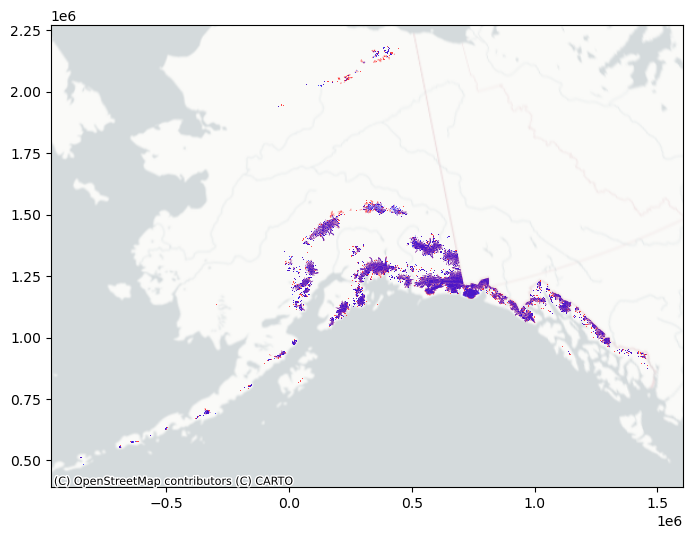

In [10]:
# Save the area difference to a variable 
df_difference = renamed_1986_df_reduced.difference(renamed_2020_df_reduced)

fig, ax = plt.subplots(figsize= (10,6))
renamed_1986_df_reduced.plot(ax=ax, color="red",label = "1986", alpha= 0.7)
renamed_2020_df_reduced.plot(ax=ax, color="blue",label = "2020", alpha = 0.7)
df_difference.plot(ax=ax, color="black",label = "Area Difference", alpha = 1)
cx.add_basemap (ax, source = cx.providers.CartoDB.Positron, crs= renamed_1986_df_reduced.crs)
plt.show()




DATA CLEANING FOR VISUALIZATION IN QGIS

In [ ]:
#Get the EPSG information for the shapefiles
renamed_1986_df_reduced.crs

In [12]:
#Determine the top 20 glaciers with the greatest decline in size
sorted_descending_glaciers = renamed_df.sort_values(by=["change_in_area"]).reset_index()
top_20_area_decrease = sorted_descending_glaciers.head(20)

#Save the glaciers ids to separate geodataframes for 1986 and 2020

top_20_1986 = top_20_area_decrease[['GLIMSId', 'longitude_1986', 'latitude_1986', 'Name_x',
       'area_1986', 'polygons_1986', "change_in_area"]]
top_20_2020 = top_20_area_decrease[['GLIMSId','longitude_2020', 'latitude_2020',
       'Name_y', 'area_2020', 'polygons_2020',"change_in_area"]]
renamed_top_20_2020 = top_20_2020.rename(columns = {"polygons_2020": "geometry", "Name_y": "Name"})
renamed_top_20_1986 = top_20_1986.rename(columns = {"polygons_1986": "geometry", "Name_x": "Name"})



renamed_top_20_2020.head()

gdf_20_1986 = gpd.GeoDataFrame(renamed_top_20_1986, geometry='geometry')

gdf_20_2020 = gpd.GeoDataFrame(renamed_top_20_2020, geometry='geometry')

# Save the GeoDataFrames to shapefiles

gdf_20_1986.to_file("../Resources/shapefiles_top_20/top_20_1986.shp")

gdf_20_2020.to_file("../Resources/shapefiles_top_20/top_20_2020.shp")






C:\Users\didem\AppData\Local\Temp\ipykernel_27012\1000809411.py:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_20_1986.to_file("../Resources/shapefiles_top_20/top_20_1986.shp")
C:\Users\didem\AppData\Local\Temp\ipykernel_27012\1000809411.py:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_20_2020.to_file("../Resources/shapefiles_top_20/top_20_2020.shp")


In [ ]:
#Save the shapefile dataframe to a csv
concat_shapefile_df.to_csv('shapefiles.csv', index=False)